<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/W1D4_Initial/tutorials/W1D4_Optimization/W1D4_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy - Deep Learning: Week 1, Day 4
# Optimization

__Content creators:__ Jose Gallego-Posada, Ioannis Mitliagkas

__Content reviewers:__ Piyush Chauhan, Vladimir Haltakov

__Content editors:__ Gagana B

__Production editors:__ Arush Tagade, Spiros Chavlis

---
#Tutorial Objectives

Objectives:
*   Necessity and Importance of Optimization
*   Introduction to commonly used optimization techniques
*   Optimization in non-convex loss landscapes 
*   Learn about Adaptive Hyperparameter Tuning 
*   Ethical concerns



---
# Setup

In [1]:
#@title Imports

from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import requests
import io
from urllib.request import urlopen
import copy
import ipywidgets as widgets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision

torch.manual_seed(31051832)
np.random.seed(31051832)

In [2]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

plt.rc('axes', unicode_minus=False)

--- 

# 1. Introduction

Video available at https://youtu.be/zm9oekdkJbQ


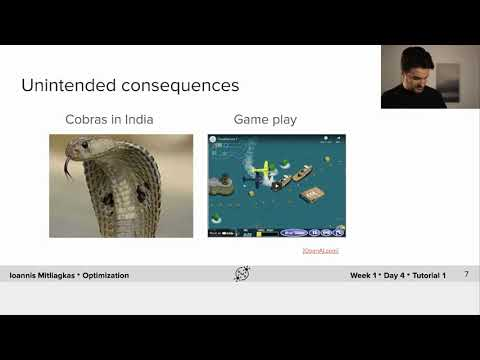

In [3]:
# TEMPLATE

#@title Video 1: Introduction
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="zm9oekdkJbQ", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---

# 2. Case study: successfully training an MLP for image classification

Many of the core ideas (and tricks) in modern optimization for deep learning can be illustrated in the simple setting of training an MLP to solve an image classification task. In this tutorial we will guide you through the key challenges that arise when optimizing high-dimensional, non-convex problems, as well as some commonly used solutions.

**Disclaimer:** Some of the functions you will code in this tutorial are already implemented in Pytorch and many other libraries. For pedagogical reasons, we decided to bring these simple coding tasks into the spotlight and place a relatively higher emphasis in your understanding of the algorithms, rather than the use of a specific library. 

In 'day-to-day' research projects you will likely to rely on the community-vetted, optimized libraries rather than the 'manual implementations' you will write today. In Section 8 you will have a chance to 'put it all together' and use the full power of Pytorch to tune the parameters of an MLP to classify handwritten digits.    


Video available at https://youtu.be/pJc2ENhYbqA


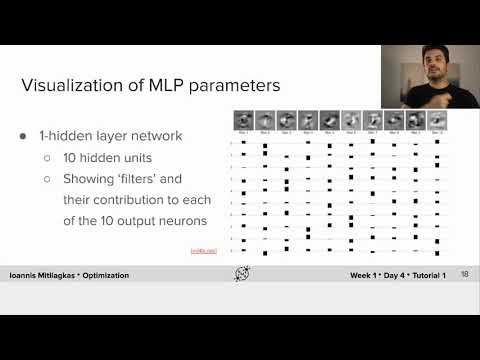

In [4]:
#@title Video 2: Case Study - MLP Classification
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="pJc2ENhYbqA", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Data

We will use the MNIST dataset of handwritten digits. We load the data via the Pytorch `datasets` module, as you learned in Day 1.   


In [5]:
def load_mnist_data(change_tensors=False):
    """Load training and test examples for the MNIST digits dataset

    Returns:
        train_data (tensor): training input tensor of size (train_size x 784)
        train_target (tensor): training 0-9 integer label tensor of size (train_size)
        test_data (tensor): test input tensor of size (70k-train_size x 784)
        test_target (tensor): training 0-9 integer label tensor of size (70k-train_size)

    """
    # Load train and test sets
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

    # Original data is in range [0, 255]. We normalize the data wrt its mean and std_dev.
    # # Note that we only used *training set* information to compute mean and std
    mean = train_set.data.float().mean()
    std = train_set.data.float().std()

    if change_tensors:
        # Apply normalization directly to the tensors containing the dataset
        train_set.data = (train_set.data.float() - mean) / std
        test_set.data = (test_set.data.float() - mean) / std
    else:

        tform = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(mean=[mean/255.],
                                                             std=[std/255.])
                                    ])
        train_set = datasets.MNIST(root='./data', train=True, download=True, transform=tform)
        test_set = datasets.MNIST(root='./data', train=False, download=True, transform=tform)

    return train_set, test_set

train_set, test_set = load_mnist_data(change_tensors=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


As we are just getting started, we will concentrate on a small subset of only 500 examples out of the 60.000 data points contained in the whole training set.



In [6]:
# Sample a random subset of 500 indices
subset_index = np.random.choice(len(train_set.data), 500)

# We will use these symbols to represent the training data and labels, to stay
# as close to the mathematical expressions as possible.
X, y = train_set.data[subset_index, :], train_set.targets[subset_index]

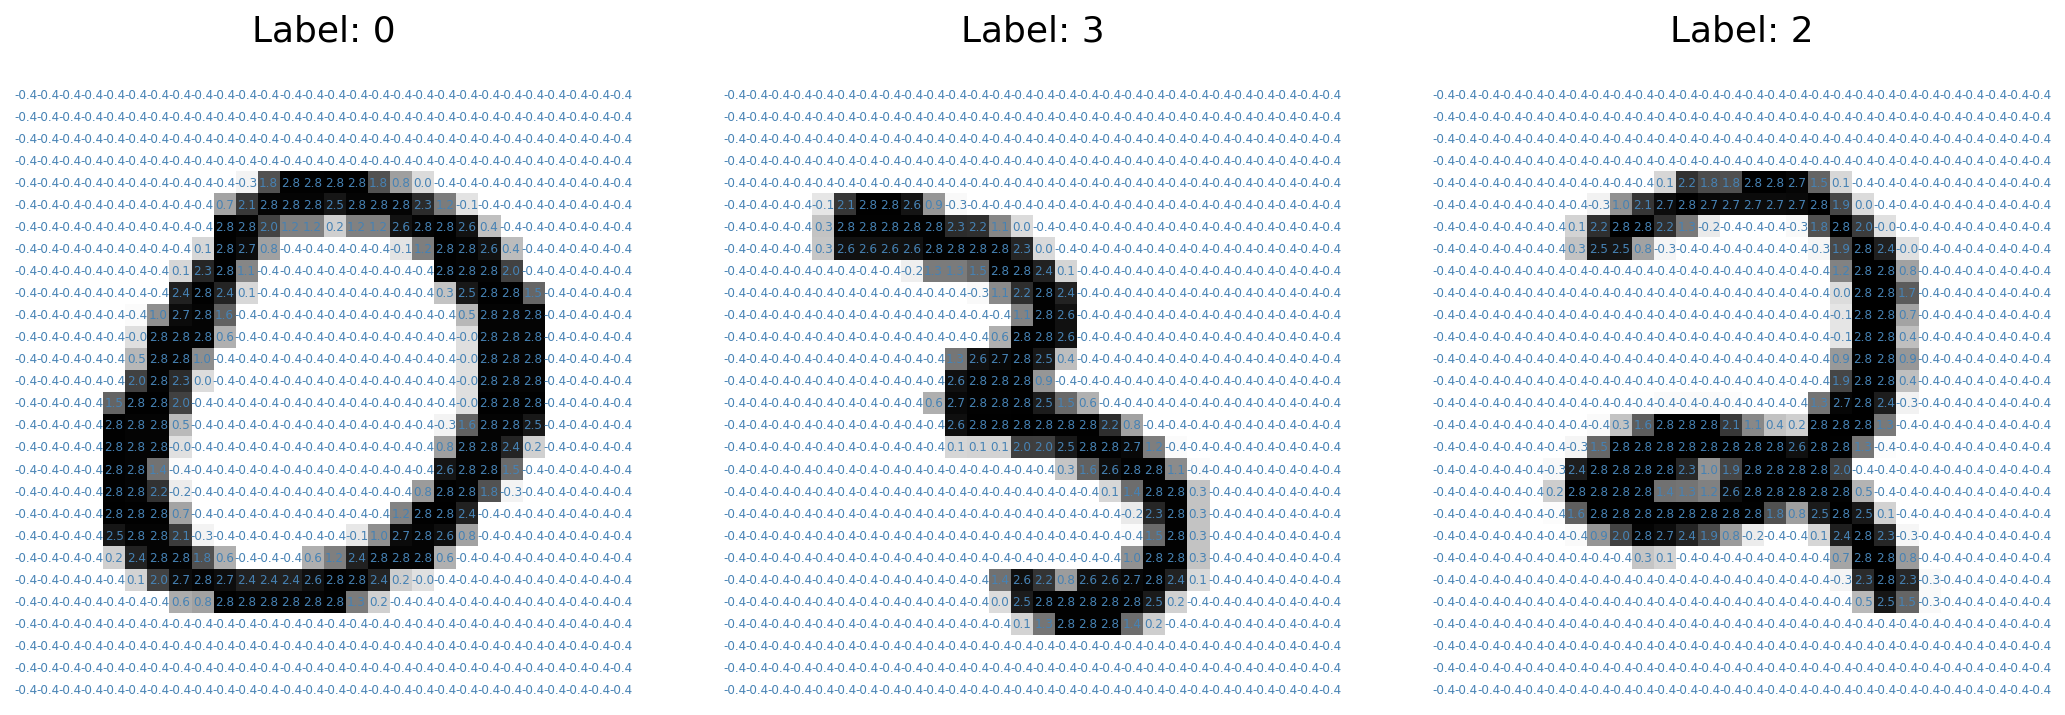

In [7]:
#@markdown Run this cell to visualize the content of three examples in our
#@markdown training set. Note how the pre-processing we applied to the data changes
#@markdown the range of pixel values after normalization.

num_figures = 3
fig, axs = plt.subplots(1, num_figures, figsize=(5*num_figures, 5))

for sample_id, ax in enumerate(axs):
    # Plot the pixel values for each image
    ax.matshow(X[sample_id, :], cmap='gray_r')
    # 'Write' the pixel value in the corresponding location
    for (i, j), z in np.ndenumerate(X[sample_id, :]):
        text = '{:.1f}'.format(z)
        ax.text(j, i, text, ha='center', va='center', fontsize=6, c='steelblue')

    ax.set_title('Label: ' + str(y[sample_id].item()))
    ax.axis('off')

plt.show()

## Model

As you will see in Week 2 Day 1, there are specific model architectures that are better suited to image-like data, such as Convolutional Neural Networks (CNNs). For simplicity, in this tutorial we will focus exclusively on Multi-Layer Perceptron (MLP) models as they allow us to highlight many important optimization challenges shared with more advanced neural network designs.

In [8]:
class MLP(nn.Module):
    """ This class implements MLPs in Pytorch of an arbitrary number of hidden
    layers of potentially different sizes. Since we concentrate on classification
    tasks in this tutorial, we have a log_softmax layer at prediction time.
    """

    def __init__(self, in_dim=784, out_dim=10, hidden_dims=[], use_bias=True):
        """Constructs a MultiLayerPerceptron

        Args:
            in_dim (int): dimensionality of input data
            out_dim (int): number of classes
            hidden_dims (list): contains the dimensions of the hidden layers, an empty
                list corresponds to a linear model (in_dim, out_dim)
        """

        super(MLP, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        # If we have no hidden layer, just initialize a linear model (e.g. in logistic regression)
        if len(hidden_dims) == 0:
            layers = [nn.Linear(in_dim, out_dim, bias=use_bias)]
        else:
            # 'Actual' MLP with dimensions in_dim - num_hidden_layers*[hidden_dim] - out_dim
            layers = [nn.Linear(in_dim, hidden_dims[0], bias=use_bias), nn.ReLU()]

            # Loop until before the last layer
            for hl_id in range(len(hidden_dims)-1):
                layers += [nn.Linear(hidden_dims[hl_id], hidden_dims[hl_id+1], bias=use_bias), nn.ReLU()]

            # Add final layer to the number of classes
            layers.append(nn.Linear(hidden_dims[-1], out_dim, bias=use_bias))

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the images into 'vectors'
        x = x.view(-1, self.in_dim)
        x = self.main(x)
        output = F.log_softmax(x, dim=1)
        return output

Linear models constitute a very special kind of MLPs: they are equivalent to an MLP with *zero* hidden layers.

$$f(x) = \text{softmax}(W x + b)$$

Here $x \in \mathbb{R}^{784}$, $W \in \mathbb{R}^{10 \times 784}$ and $b \in \mathbb{R}^{10}$.

In [9]:
# Empty hidden_dims means we take a model with zero hidden layers.
model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

## Loss

While we care about the accuracy of the model, the 'discrete' nature of the 0-1 loss makes it challenging to optimize. In order to learn good parameters for this model, we will use the cross entropy loss (negative log-likelihood), which you saw in last lecture, as a surrogate objective to be minimized. 

This particular choice of model and optimization objective leads to a *convex* optimization problem with respect to the parameters $W$ and $b$. 

In [10]:
loss_fn = F.nll_loss

## Interpretability

In [11]:
#@markdown In last lecture, you saw that inspecting the weights of a model can provide
#@markdown insights on what 'concepts' the model has learned. Here we show the weights
#@markdown of a partially trained model. The weights corresponding to each class
#@markdown 'learn' to _fire_ when an input of the class is detected.

#@markdown Run _this cell_ to train the model. If you are curious about how the training
#@markdown takes place, double-click this cell to find out. At the end of this tutorial
#@markdown you will have the opportunity to train a more complex model on your own.

cell_verbose = False
partial_trained_model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

if cell_verbose:
    print('Init loss', loss_fn(partial_trained_model(X), y).item()) # This matches around np.log(10 = # of classes)

optimizer = optim.Adam(partial_trained_model.parameters(), lr=7e-4)
for _ in range(200):
    loss = loss_fn(partial_trained_model(X), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

if cell_verbose:
    print('End loss', loss_fn(partial_trained_model(X), y).item()) # This should be less than 1e-2

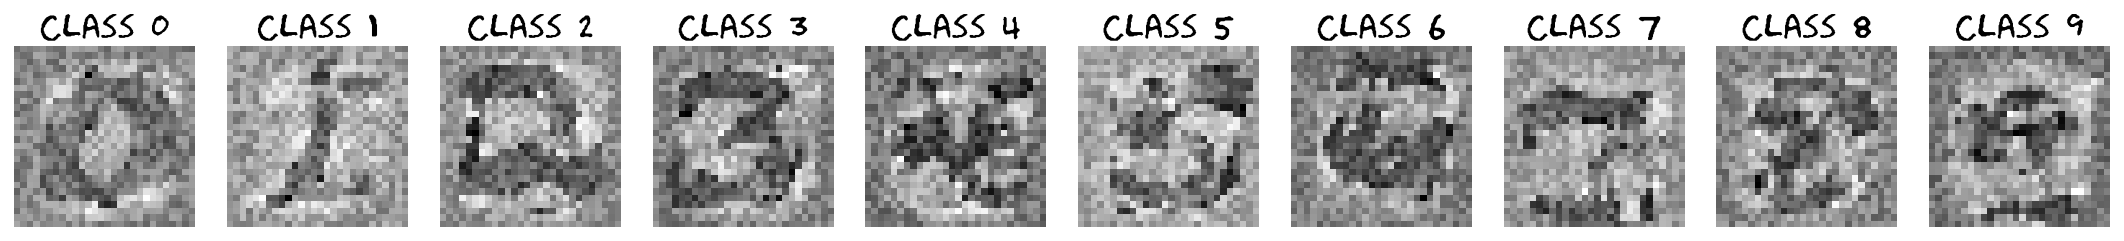

In [12]:
# Show class filters of a trained model
W = partial_trained_model.main[0].weight.data.numpy()

with plt.xkcd():
    fig, axs = plt.subplots(1, 10, figsize=(15,4))
    for class_id in range(10):
        axs[class_id].imshow(W[class_id, :].reshape(28, 28), cmap='gray_r')
        axs[class_id].axis('off')
        axs[class_id].set_title('Class ' + str(class_id) )

plt.show()

# 3. High dimensional search

We now have a model with its corresponding trainable parameters as well as an objective to optimize. Where do we go to next? How do we find a 'good' configuration of parameters?

One idea is to choose a random direction and move only if the objective is reduced. However, this is inefficient in high dimensions and you will see how gradient descent (with a suitable step-size) can guarantee consistent improvement in terms of the objective function.

Video available at https://youtu.be/aSJTRdjRvvw


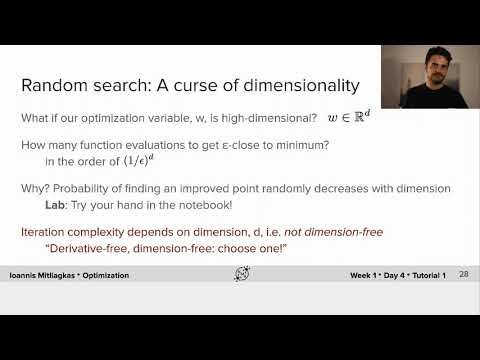

In [13]:
#@title Video 3: Optimization of an Objective Function
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="aSJTRdjRvvw", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Exercise 1: Implement gradient descent

In this exercise you will use Pytorch automatic differentiation capabilities to compute the gradient of the loss with respect to the parameters of the model. You will then use these gradients to implement the update performed by the gradient descent method.  

In [14]:
def zero_grad(params):
    """Clear up gradients as Pytorch automatically accumulates gradients from
    successive backward calls
    """
    for par in params:
        if not(par.grad is None):
            par.grad.data.zero_()

def random_update(model, noise_scale=0.1, normalized=False):
    """ Performs a random update on the parameters of the model
    """
    for par in model.parameters():
        noise = torch.randn_like(par)
        if normalized:
            noise /= torch.norm(noise)
        par.data +=  noise_scale * noise

In [15]:
def gradient_update(loss, params, lr=1e-1):
    """Perform a gradient descent update on a given loss over a collection of parameters

    Args:
        loss (tensor): A scalar tensor containing the loss whose gradient will be computed
        params (iterable): Collection of parameters with respect to which we compute gradients
        lr (float): Scalar specifying the learning rate or step-size for the update

    """

    # Clear up gradients as Pytorch automatically accumulates gradients from
    # successive backward calls
    zero_grad(params)

    # Compute gradients on given objective
    loss.backward()

    for par in params:
        #################################################
        ## TODO for students: update the value of the parameter ##

        # Here we work with the 'data' attribute of the parameter rather than the
        # parameter itself. Use the random_update function above to inspire your solution.
        par.data = ...

        raise NotImplementedError("Student exercise: implement gradient update")
        #################################################

In [16]:
# to_remove solution
def gradient_update(loss, params, lr=1e-1):
    """Perform a gradient descent update on a given loss over a collection of parameters

    Args:
        loss (tensor): A scalar tensor containing the loss whose gradient will be computed
        params (iterable): Collection of parameters with respect to which we compute gradients
        lr (float): Scalar specifying the learning rate or step-size for the update

    """

    # Clear up gradients as Pytorch automatically accumulates gradients from
    # successive backward calls
    zero_grad(params)

    # Compute gradients on given objective
    loss.backward()

    for par in params:
        # Here we work with the 'data' attribute of the parameter rather than the
        # parameter itself.
        par.data -=  lr * par.grad.data

### Comparing updates

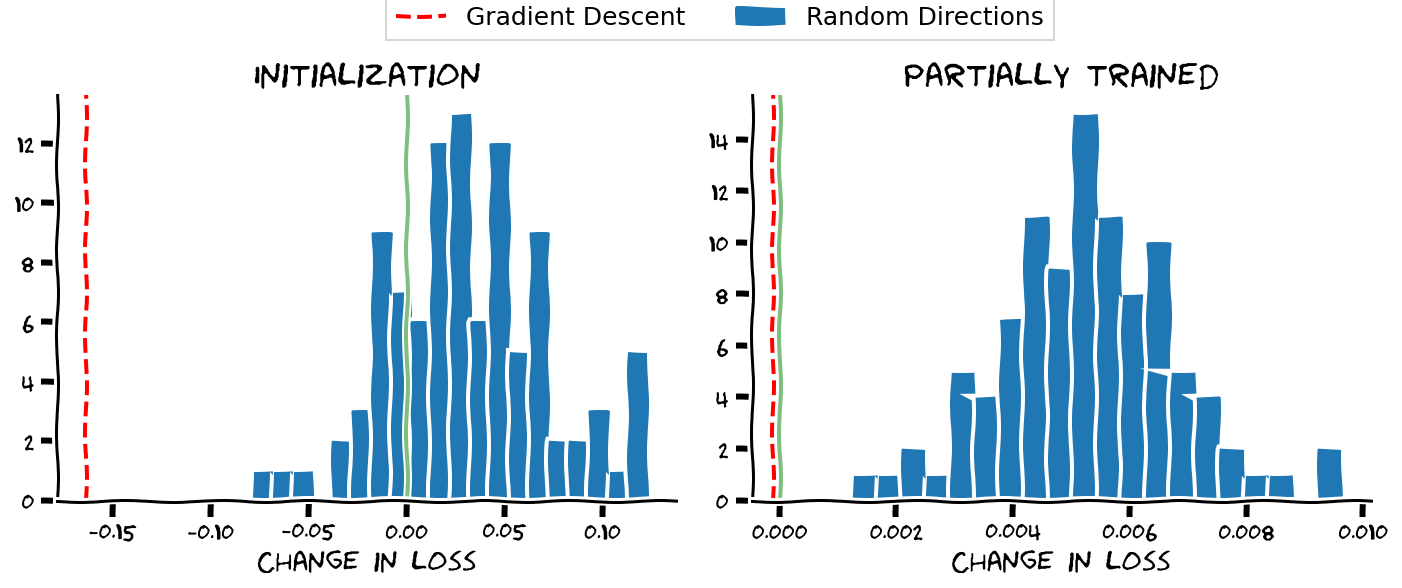

In [17]:
#@markdown These plots compare the effectiveness of updating random
#@markdown directions for the problem of optimizing the parameters
#@markdown of a high-dimensional linear model. We contrast the behavior at
#@markdown initialization and during an intermediate stage of training by showing
#@markdown the histograms of change in loss over 100 different random directions
#@markdown vs the changed in loss induced by the gradient descent update -- negative is better.

with plt.xkcd():

    fig, axs = plt.subplots(1, 2, figsize=(10,4))

    for id, (model_name, my_model) in enumerate([('Initialization', model),
                                ('Partially trained', partial_trained_model)]):

        # Compue the loss we will be comparing to
        base_loss = loss_fn(my_model(X), y)

        # Compute the improvement via gradient descent
        dummy_model = copy.deepcopy(my_model)
        loss1 = loss_fn(dummy_model(X), y)
        gradient_update(loss1, list(dummy_model.parameters()), lr=1e-2)
        gd_delta = loss_fn(dummy_model(X), y) - base_loss

        deltas = []
        for trial_id in range(100):
            # Compute the improvement obtained with a random direction
            dummy_model = copy.deepcopy(my_model)
            random_update(dummy_model, noise_scale=1e-2)
            deltas.append((loss_fn(dummy_model(X), y) - base_loss).item())

        # Plot histogram for random direction and vertical line for gradient descent
        axs[id].hist(deltas, label='Random Directions', bins=20)
        axs[id].set_title(model_name)
        axs[id].set_xlabel('Change in loss')
        axs[id].axvline(0, c='green', alpha=0.5)
        axs[id].axvline(gd_delta.item(), linestyle='--', c='red', alpha=1, label='Gradient Descent')


handles, labels = axs[id].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 1.05), fancybox=False, shadow=False, ncol=2)

plt.show()

**Remarks:** Note how gradient descent (with a properly tuned step size) guarantees an improvement in the objective function, unlike the random udpate method, which very rarely finds a direction that improves the objective function. The magnitue of the improvement at initialization is much bigger than the change in loss obtained at a later stage in training. This is expected, as we have gotten closer to the optimum parameter configuration.  

# 4. Poor conditioning

Already in this 'simple' logistic regression problem, the issue of bad conditioning is haunting us. Not all parameters are created equal and the sensitivity of the network to changes on the parameters will have a big impact in the dynamics of the optimization.

Video available at https://youtu.be/3ES5O58Y_2M


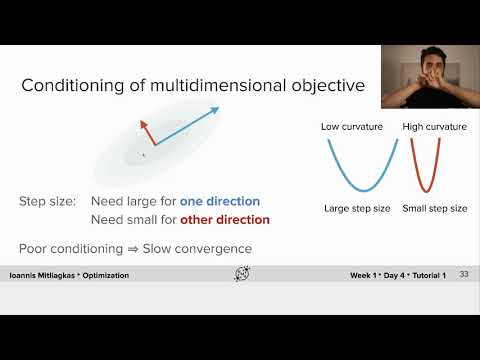

In [18]:
#@title Video 4: Momentum
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="3ES5O58Y_2M", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In [19]:
#@markdown We illustrate this issue in a 2-dimensional setting. We freeze all but
#@markdown two parameters of the network: one of them is an element of the weight matrix (filter)
#@markdown for class 0, while the other is the bias for class 7. This results in
#@markdown an optimization with two decision variables.

#@markdown How much difference is there in the behavior of these two parameters
#@markdown under gradient descent? What is the effect of momentum in bridging that gap?

#@markdown Run _this cell_ to setup some helper functions.

def loss_2d(model, u, v, mask_idx=(0, 378), bias_id=7):
    """Defines a 2-dim function by freezing all but two parameters of a linear
    model.

    Args:
        model (torch module): a pytorch 0-hidden layer (linear) model
        u (scalar): first free parameter
        v (scalar): second free parameter
        mask_idx (tuple): selects parameter in weight matrix replaced by u
        bias_idx (int): selects parameter in bias vector replaced by v

    Returns:
        scalar: loss of the 'new' model over inputs X, y (defined externally)
    """

    # We zero out the element of the weight tensor that will be
    # replaced by u
    mask = torch.ones_like(model.main[0].weight)
    mask[mask_idx[0], mask_idx[1]] = 0.
    masked_weights = model.main[0].weight * mask

    # u is replacing an element of the weight matrix
    masked_weights[mask_idx[0], mask_idx[1]] = u

    res = X.reshape(-1, 784) @ masked_weights.T + model.main[0].bias

    # v is replacing a bias for class 7
    res[:, 7] += v - model.main[0].bias[7]
    res =  F.log_softmax(res, dim=1)

    return loss_fn(res, y)

def plot_surface(U, V, Z, fig):
    """ Plot a 3D loss surface given meshed inputs U, V and values Z
    """

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.view_init(45, -130)

    surf = ax.plot_surface(U, V, Z, cmap=plt.cm.coolwarm,
                        linewidth=0, antialiased=True, alpha=0.5)

    # Select certain level contours to plot
    # levels = Z.min() * np.array([1.005, 1.1, 1.3, 1.5, 2.])
    # plt.contour(U, V, Z)# levels=levels, alpha=0.5)

    ax.set_xlabel('Weight')
    ax.set_ylabel('Bias')
    ax.set_zlabel('Loss', rotation=90)

    return ax

def plot_param_distance(best_u, best_v, trajs, fig, styles, labels, use_log=False):
    """ Plot the distance to each of the two parameters for a collection of 'trajectories'
    """
    with plt.xkcd():

        ax = fig.add_subplot(1, 1, 1)

        for traj, style, label in zip(trajs, styles, labels):

            d0 = [np.abs(_[0] - best_u) for _ in traj]
            d1 = [np.abs(_[1] - best_v) for _ in traj]

            if use_log:
                d0 = np.log(d0)
                d1 = np.log(d1)

            ax.plot(range(len(traj)), d0, style, label='weight - ' + label)
            ax.plot(range(len(traj)), d1, style, label='bias - ' + label)

        ax.set_xlabel('Iteration')
        if use_log:
            ax.set_ylabel('Log Abs distance to optimum')
        else:
            ax.set_ylabel('Abs distance to optimum')
        ax.legend(loc='right', bbox_to_anchor=(1.5, 0.5),
                  fancybox=False, shadow=False, ncol=1)

    return ax


def run_optimizer(inits, eval_fn, update_fn, max_steps=500, optim_kwargs={'lr':1e-2},
                  log_traj=True):

    """Runs an optimizer on a given objective and logs parameter trajectory

    Args:
        inits list(scalar): initialization of parameters
        eval_fn (callable): function computing the objective to be minimized
        update_fn (callable): function executing parameter update
        max_steps (int): number of iterations to run
        optim_kwargs (dict): customize optimizer hyperparameters

    Returns:
        list[list]: trajectory information [*params, loss] for each optimization step
    """

    # Initialize parameters and optimizer
    params = [nn.Parameter(torch.tensor(_)) for _ in inits]

    # Methods like momentum and rmsprop keep and auxiliary vector of parameters
    aux_tensors = [torch.zeros_like(_) for _ in params]

    if log_traj:
        traj = np.zeros((max_steps, len(params)+1))

    for _ in range(max_steps):

        # Evaluate loss
        loss = eval_fn(*params)

        # Store 'trajectory' information
        if log_traj:
            traj[_, :] = [_.item() for _ in params] + [loss.item()]

        # Perform update
        if update_fn == gradient_update:
            gradient_update(loss, params, **optim_kwargs)
        else:
            update_fn(loss, params, aux_tensors, **optim_kwargs)

    if log_traj:
        return traj


L = 4.
xs = np.linspace(-L, L, 30)
ys = np.linspace(-L, L, 30)
U, V = np.meshgrid(xs, ys)

### Exercise 2: Implement momentum

In this exercise you will implement the momentum update given by:
$$w_{t+1} = w_t - \eta \nabla J(w_t) + \beta (w_t - w_{t-1})$$

It is convenient to re-express this update rule in terms of a recursion. For that, we define the quantity:
$$v_{t-1} := w_{t} - w_{t-1},$$
which leads to the two-step update rule:
$$ v_t = - \eta \nabla J(w_t) + \beta (\underbrace{w_t - w_{t-1}}_{v_{t-1}})$$
$$ w_{t+1} \leftarrow w_t + v_{t}$$

Pay attention to the positive sign of the update in the last equation, given the definition of $v_t$, above. 

In [20]:
def momentum_update(loss, params, grad_vel, lr=1e-1, beta=0.8):
    """Perform a momentum update over a collection of parameters given a loss and 'velocities'

    Args:
        loss (tensor): A scalar tensor containing the loss whose gradient will be computed
        params (iterable): Collection of parameters with respect to which we compute gradients
        grad_vel (iterable): Collection containing the 'velocity' v_t for each parameter
        lr (float): Scalar specifying the learning rate or step-size for the update
        beta (float): Scalar 'momentum' parameter

    """

    # Clear up gradients as Pytorch automatically accumulates gradients from
    # successive backward calls
    zero_grad(params)

    # Compute gradients on given objective
    loss.backward()

    for (par, vel) in zip(params, grad_vel):

        #################################################
        ## TODO for students: update the value of the parameter ##

        # Update 'velocity'
        vel.data = ...

        # Update parameters
        par.data = ...

        raise NotImplementedError("Student exercise: implement momentum update")
        #################################################

In [21]:
# to_remove solution
def momentum_update(loss, params, grad_vel, lr=1e-1, beta=0.8):
    """Perform a momentum update over a collection of parameters given a loss and 'velocities'

    Args:
        loss (tensor): A scalar tensor containing the loss whose gradient will be computed
        params (iterable): Collection of parameters with respect to which we compute gradients
        grad_vel (iterable): Collection containing the 'velocity' v_t for each parameter
        lr (float): Scalar specifying the learning rate or step-size for the update
        beta (float): Scalar 'momentum' parameter

    """

    # Clear up gradients as Pytorch automatically accumulates gradients from
    # successive backward calls
    zero_grad(params)

    # Compute gradients on given objective
    loss.backward()

    for (par, vel) in zip(params, grad_vel):

        # Update 'velocity'
        vel.data = -lr * par.grad.data + beta * vel.data

        # Update parameters
        par.data += vel.data

### Momentum vs GD

In [22]:
#@markdown The plots below show the distance to the optimum for both variables
#@markdown accros the two methos, as well as the parameter trajectory over the loss
#@markdown surface.

# Compute loss surface
g = lambda u, v: loss_2d(copy.deepcopy(model), u, v)
Z = np.fromiter(map(g, U.ravel(), V.ravel()), U.dtype).reshape(V.shape)
min_idx = np.unravel_index(np.argmin(Z), Z.shape)
best_u, best_v = U[min_idx], V[min_idx]

# Initialization of the variables
INITS = [2.5, 3.7]

# Used for plotting
LABELS = ['GD', 'Momentum']
COLORS = ['black', 'red']
LSTYLES = ['-', '--']

@widgets.interact
def momentum_experiment(max_steps=widgets.IntSlider(200, 50, 500, 5),
                        lr=widgets.FloatLogSlider(value=1e-1, min=-3, max=0, step=0.1)):

    # Execute both optimizers
    sgd_traj = run_optimizer(INITS, eval_fn=g, update_fn=gradient_update,
                    max_steps=max_steps, optim_kwargs={'lr': lr})
    mom_traj = run_optimizer(INITS, eval_fn=g, update_fn=momentum_update,
                    max_steps=max_steps, optim_kwargs={'lr': lr, 'beta':0.9})

    TRAJS = [sgd_traj, mom_traj]

    # Plot distances
    fig = plt.figure(figsize=(9,4))
    plot_param_distance(best_u, best_v, TRAJS, fig, LSTYLES, LABELS, use_log=True)

    # # Plot trajectories
    fig = plt.figure(figsize=(12, 5))
    with plt.xkcd():
        ax = plot_surface(U, V, Z, fig)
        for traj, c, label in zip(TRAJS, COLORS, LABELS):
            ax.plot3D(*traj.T, c, linewidth=0.3, label=label)
            ax.scatter3D(*traj.T, '.-', s=1, c=c);

        # Plot optimum point
        ax.scatter(best_u, best_v, Z.min(), marker='*', s=80, c='lime', label='Opt.');

        from matplotlib.lines import Line2D
        lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in COLORS]
        lines.append(Line2D([0], [0], color='lime', linewidth=0, marker='*'))
        ax.legend(lines, LABELS + ['Optimum'], loc='right', bbox_to_anchor=(.8, -0.1), ncol=len(LABELS)+1)

interactive(children=(IntSlider(value=200, description='max_steps', max=500, min=50, step=5), FloatLogSlider(v…

**Remarks:**  Note that the loss has very different curvatures between the weight and the bias dimensions: a change of the same magnitude has a much bigger effect in the loss when applied to the weight than to the bias. This leads to very slow convergence of GD in the weight dimension.

Momentum encourages 'movement' in previously seen directions and results in  both parameters converging much faster. The oscillations you can see for the momentum trajectories arise due to overshooting past the solution due to the momentum term.


# 5. Non-convexity

The introduction of even just 1 hidden layer in the neural network transforms the previous convex optimization problem into a non-convex one. And with great non-convexity, comes great responsibility... (Sorry, we couldn't help it!)

Video available at https://youtu.be/7vUpUEKKl5o


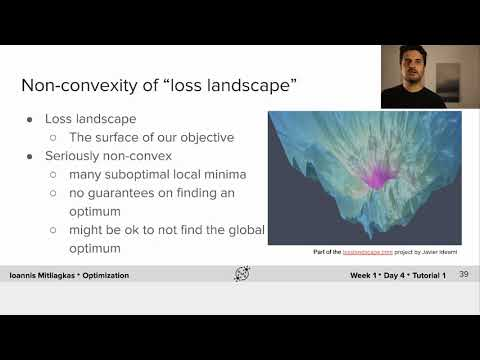

In [23]:
#@title Video 5: Overparametrization
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="7vUpUEKKl5o", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Take a couple of minutes to play with a more complex 3D visualization of the loss landscape of a neural network on a non-convex problem. Visit https://losslandscape.com/explorer.

1. Explore the features on the bottom left corner. You can see an explanation for each icon by clicking on the [i] button located on the top right corner.
2. Use the 'gradient descent' feature to perform a thought experiment:
    -   Choose an initialization
    -   Choose the learning rate
    -   Mentally formulate your hypothesis about what kind of trajectory you expect to observe 
3. Run the experiment and contrast your intuition with the observed behavior.
4. Repeat this experiment a handful of times for several initialization/learning rate configurations


### Overparametrization to the rescue!

As you may have seen, the non-convex nature of the surface can lead the optimization process to get stuck in undesirable local-optima. There is ample empirical evidence supporting the claim that 'overparameterized' models are easier to train.

We will explore this assertion in the context of our MLP training. For this, we initialize a fixed model and construct several models by small random perturbations to the original initialized weights. Now, we train each of these perturbed models and see how the loss evolves. If we were in the convex setting, we should reach very similar objective values upon convergence since all these models were very close at the beginning of training, and in convex problems, every local optimum is also a global optimum.

Use the interactive plot below to visualize the loss progression for these perturbed models:

1. Select different settings from the `hidden_dims` drop-down menu.
2. Explore the effect of the number of steps and learning rate.

In [24]:
#@markdown Execute this cell to enable the widget!

@widgets.interact
def overparam(max_steps=widgets.IntSlider(150, 50, 500, 5),
              hidden_dims=widgets.Dropdown(options=["10", "20, 20", "100, 100"],
                                           value="10"),
              lr=widgets.FloatLogSlider(value=5e-2, min=-3, max=0, step=0.1),
              num_inits=widgets.IntSlider(7, 5, 10, 1)):

    print('Generating plot')

    X, y = train_set.data[subset_index, :], train_set.targets[subset_index]

    hdims = [int(s) for s in hidden_dims.split(',')]
    base_model = MLP(in_dim=784, out_dim=10, hidden_dims=hdims)

    with plt.xkcd():
        fig, axs = plt.subplots(1, 1, figsize=(5,4))

        for _ in range(num_inits):

            model = copy.deepcopy(base_model)
            random_update(model, noise_scale=2e-1)

            loss_hist = np.zeros((max_steps, 2))
            for step in range(max_steps):
                loss = loss_fn(model(X), y)
                gradient_update(loss, list(model.parameters()), lr=lr)
                loss_hist[step] = np.array([step, loss.item()])

            plt.plot(loss_hist[:, 0], loss_hist[:, 1])

    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.ylim(0, 3);

    num_params = sum([np.prod(_.shape) for _ in model.parameters()])
    print('Plot ready - Model # parameters:  ' + str(num_params))

interactive(children=(IntSlider(value=150, description='max_steps', max=500, min=50, step=5), Dropdown(descrip…

**Remarks:** 'Overparameterized' models reliably lead to lower loss values regardless of the perturbation of the parameters at initialization, reaching very similar local optima despite the non-convexity of the landscape. This is in stark constrast for models with low number of paramers, for which the model can get stuck in local optima of a relatively big variance in terms of the objective function values.

# 6. Full gradients are expensive

So far we have used only a small (fixed) subset of 500 trainig examples to performe the updates on the model parameters in our quest to minimize the loss. But what if we decided to use the training set? Do our current approach scale to datasets with tens of thousands, or millions of datapoints?

In this section we explore an efficient alternative to avoid having to perform computations on all the training examples before performing a parameter update.

Video available at https://youtu.be/hbqUxpNBUGk


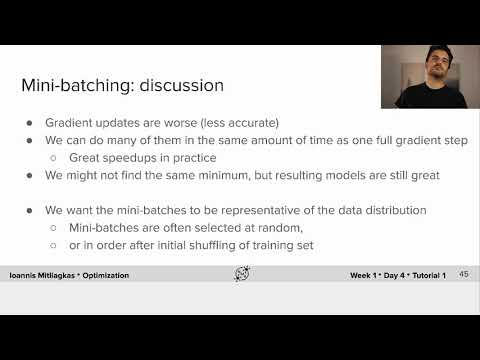

In [25]:
#@title Video 6: Mini-batches
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="hbqUxpNBUGk", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Cost of computation

Evaluating a neural network is a relatively fast process. However, when repeated millions of times, the computational cost of performing forward and backwards passes through the network starts becoming significant.

In the visualization below, we show the time (averaged over 10 runs) of computing a forward and backward pass with a changing number of input examples. Choose from the different options in the drop-down box and note how the vertical scale changes depending on the size of the network. 

**Remarks:** Note the computational cost of a forward pass follows a clear linear trend depending on the number of input examples, as well as how the cost of the corresponding backward pass has a similar computational complexity.

In [26]:
#@markdown Execute this cell to enable the widget!

def measure_update_time(model, num_points):
    X, y = train_set.data[:num_points], train_set.targets[:num_points]
    start_time = time.time()

    loss = loss_fn(model(X), y)
    loss_time = time.time()

    gradient_update(loss, list(model.parameters()), lr=0)
    gradient_time = time.time()

    return loss_time - start_time, gradient_time - loss_time

@widgets.interact
def computation_time(hidden_dims=widgets.Dropdown(options=["10",
                                                           "100",
                                                           "50, 50"],
                                           value="10")):

    hdims = [int(s) for s in hidden_dims.split(',')]
    model = MLP(in_dim=784, out_dim=10, hidden_dims=hdims)

    NUM_POINTS = [1, 5, 10, 100, 200, 500, 1000, 5000, 10000, 20000, 30000, 50000]
    times_list = []
    for _ in range(5):
        times_list.append(np.array([measure_update_time(model, _) for _ in NUM_POINTS]))

    times = np.array(times_list).mean(axis=0)


    with plt.xkcd():
        fig, axs = plt.subplots(1, 1, figsize=(5,4))
        plt.plot(NUM_POINTS, times[:, 0], label='Forward')
        plt.plot(NUM_POINTS, times[:, 1], label='Backward')
        plt.xlabel('Number of data points')
        plt.ylabel('Seconds')
        plt.legend()

interactive(children=(Dropdown(description='hidden_dims', options=('10', '100', '50, 50'), value='10'), Output…

### Exercise 3: Implement minibatch sampling

Complete the code in `sample_minibatch` so as to produce IID subsets of the training set of the desired size. (This is _not_ a trick question.) 

In [27]:
def sample_minibatch(input_data, target_data, num_points=100):
    """Sample a minibatch of size num_point from the provided input-target data

    Args:
        input_data (tensor): Multi-dimensional tensor containing the input data
        input_data (tensor): 1D tensor containing the class labels
        num_points (int): Number of elements to be included in minibatch

    Returns:
        batch_inputs (tensor): Minibatch inputs
        batch_targets (tensor): Minibatch targets

    """

    #################################################
    ## TODO for students: sample minibatch of data ##

    # Sample a collection of IID indices from the existing data
    batch_indices = ...

    # Use batch_indices to extract entries from the input and target data tensors
    batch_inputs = input_data[...]
    batch_targets = target_data[...]

    raise NotImplementedError("Student exercise: implement gradient update")
    #################################################

    return batch_inputs, batch_targets

In [28]:
# to_remove solution
def sample_minibatch(input_data, target_data, num_points=100):
    """Sample a minibatch of size num_point from the provided input-target data

    Args:
        input_data (tensor): Multi-dimensional tensor containing the input data
        input_data (tensor): 1D tensor containing the class labels
        num_points (int): Number of elements to be included in minibatch

    Returns:
        batch_inputs (tensor): Minibatch inputs
        batch_targets (tensor): Minibatch targets

    """

    # Sample a collection of IID indices from the existing data
    batch_indices = np.random.choice(len(input_data), num_points)

    # Use batch_indices to extract entries from the input and target data tensors
    batch_inputs = input_data[batch_indices, :]
    batch_targets = target_data[batch_indices]

    return batch_inputs, batch_targets

### Compare different minibatch sizes

What are the trade-offs induced by the choice of minibatch size? The interactive plot below show the training evolution of a 2-hidden layer MLP with 100 hidden units in each hidden layer. Different plots correspond to a different choice of minibatch size. We have a fixed time budget for all the cases, reflected in the horizontal axes of these plots.

In [29]:
#@markdown Execute this cell to enable the widget!

@widgets.interact
def minibatch_experiment(batch_sizes='20, 250, 1000',
                         lrs='5e-3, 5e-3, 5e-3',
                         time_budget=widgets.FloatSlider(value=5.0, min=3.0, max=10., step=0.1)):

    batch_sizes = [int(s) for s in batch_sizes.split(',')]
    lrs = [float(s) for s in lrs.split(',')]

    LOSS_HIST = {_:[] for _ in batch_sizes}

    X, y = train_set.data, train_set.targets
    base_model = MLP(in_dim=784, out_dim=10, hidden_dims=[100, 100])

    for id, batch_size in enumerate(batch_sizes):

        start_time = time.time()

        # Create a new copy of the model for each batch size
        model = copy.deepcopy(base_model)
        params = list(model.parameters())
        lr = lrs[id]

        # Fixed budget per choice of batch size
        while (time.time() - start_time) < time_budget:
            batch_x, batch_y = sample_minibatch(X, y, batch_size)
            loss = loss_fn(model(batch_x), batch_y)
            gradient_update(loss, params, lr=lr)
            LOSS_HIST[batch_size].append([time.time() - start_time, loss.item()])

    with plt.xkcd():
        fig, axs = plt.subplots(1, len(batch_sizes), figsize=(10,3))

        for ax, batch_size in zip(axs, batch_sizes):

            plot_data = np.array(LOSS_HIST[batch_size])
            ax.plot(plot_data[:, 0], plot_data[:, 1], label=batch_size, alpha=0.8)
            ax.set_title('Batch size: ' + str(batch_size))
            ax.set_xlabel('Seconds')
            ax.set_ylabel('Loss')

interactive(children=(Text(value='20, 250, 1000', description='batch_sizes'), Text(value='5e-3, 5e-3, 5e-3', d…

**Remarks:** SGD works! We have an algorithm that can be applied (with the due precautions) to learn datasets of arbitrary size. 

However, note the diference in the vertical scale across the plots above. When using a larger minibatch, we can perform fewer parameter updates as the forward and backward passes are more expensive.

This highlights the interplay between the minibatch size and the learning rate: when our minibatch is larger, we have a more confident estimator of the direction to move, and thus can afford a larger learning rate. On the other hand, extremely small minibatches are very fast computationally but are not representative of the data distribution and yield estimations of the gradient with high variance.

We encourage you to tune the value of the learning rate for each of the minibatch sizes in the previous demo, to achieve a training loss steadily below 0.5 within 5 seconds.

# 7. Hyperparameter tuning - Adaptive methods

As of now, you should be aware that there are many knobs to turn when working on a machine learning problem. Some of these relate to the optimization algorithm, to the choice of model, or to the objective to minimize. Here are some prototypical examples:

- Problem: loss function, regularization coefficients (Day 5)
- Model: architecture, activations function
- Optimizer: learning rate, batch size, momentum coefficient

We concentrate on the choices that are directly related with optimization. In particular, we will explore some _automatic_ methods for setting the learning rate, in a way that fixes the poor-conditioning problem and is robust across different problems.

Video available at https://youtu.be/rxJfoTw20x8


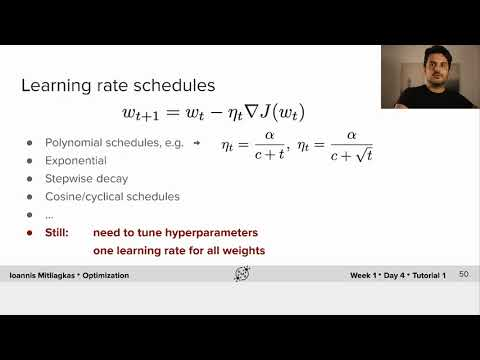

In [30]:
#@title Video 7: Adaptive Methods
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="rxJfoTw20x8", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Exercise 4: Implement RMSprop

In this exercise you will implement the update of the RMSprop optimizer:

$$ w_{t+1} = w_t - \eta \frac{\nabla J(w_t)}{\sqrt{v_t + \epsilon}}$$

$$ v_{t+1} = \alpha v_t + (1 - \alpha) \nabla J(w_t)^2,$$

where the non-standard operations (division of two vectors, squaring a vector, etc) are to be interpreted as element-wise operations, i.e., the operation is applied to each (pair of) entry[ies] of the vector(s) considered as real number(s).

Here, the $\epsilon$ hyperparameter provides numerical estability to the algorithm, by preventing the learning rate to become too big when $v_t$ is small. Typically, we set $\epsilon$ to a default small value, like $10^{-8}$.  

In [31]:
def rmsprop_update(loss, params, grad_sq, lr=1e-1, alpha=0.8):
    """Perform an RMSprop update on a collection of parameters

    Args:
        loss (tensor): A scalar tensor containing the loss whose gradient will be computed
        params (iterable): Collection of parameters with respect to which we compute gradients
        grad_sq (iterable): Moving average of squared gradients
        lr (float): Scalar specifying the learning rate or step-size for the update
        alpha (float): Moving average parameter

    """

    # Clear up gradients as Pytorch automatically accumulates gradients from
    # successive backward calls
    zero_grad(params)

    # Compute gradients on given objective
    loss.backward()

    for (par, gsq) in zip(params, grad_sq):

        #################################################
        ## TODO for students: update the value of the parameter ##

        # Update estimate of gradient variance
        gsq.data = alpha * gsq.data + (1-alpha) * par.grad**2

        # Update parameters
        par.data -=  lr * (par.grad / (1e-8 + gsq.data)**0.5)

        raise NotImplementedError("Student exercise: implement gradient update")
        #################################################

In [32]:
# to_remove solution
def rmsprop_update(loss, params, grad_sq, lr=1e-1, alpha=0.8):
    """Perform an RMSprop update on a collection of parameters

    Args:
        loss (tensor): A scalar tensor containing the loss whose gradient will be computed
        params (iterable): Collection of parameters with respect to which we compute gradients
        grad_sq (iterable): Moving average of squared gradients
        lr (float): Scalar specifying the learning rate or step-size for the update
        alpha (float): Moving average parameter

    """

    # Clear up gradients as Pytorch automatically accumulates gradients from
    # successive backward calls
    zero_grad(params)

    # Compute gradients on given objective
    loss.backward()

    for (par, gsq) in zip(params, grad_sq):
        # Update estimate of gradient variance
        gsq.data = alpha * gsq.data + (1-alpha) * par.grad**2

        # Update parameters
        par.data -=  lr * (par.grad / (1e-8 + gsq.data)**0.5)

### Compare optimizers

Below, we compare your implementations of SGD, momentum and RMSprop. If you have successfully coded all the exercises so far: congrats! You are *now in the know* of some of the most commonly used and powerful tools of optimization for deep learning. 

In [33]:
#@markdown Execute this cell to enable the widget!

X, y = train_set.data, train_set.targets

@widgets.interact
def compare_optimizers(batch_size=(25, 250, 5),
                       lr=widgets.FloatLogSlider(value=2e-3, min=-5, max=0),
                       max_steps=(50, 500, 5)):

    SGD_DICT = [gradient_update, 'SGD', 'black', '-', {'lr': lr}]
    MOM_DICT = [momentum_update, 'Momentum', 'red', '--', {'lr': lr, 'beta': 0.8}]
    RMS_DICT = [rmsprop_update, 'RMSprop', 'fuchsia', '-', {'lr': lr, 'alpha': 0.8}]

    ALL_DICTS = [SGD_DICT, MOM_DICT, RMS_DICT]

    base_model = MLP(in_dim=784, out_dim=10, hidden_dims=[100, 100])

    LOSS_HIST = {}

    for opt_dict in ALL_DICTS:
        update_fn, opt_name, color, lstyle, kwargs = opt_dict
        LOSS_HIST[opt_name] = []

        model = copy.deepcopy(base_model)
        params = list(model.parameters())

        if opt_name != 'SGD':
            aux_tensors = [torch.zeros_like(_) for _ in params]

        for step in range(max_steps):
            batch_x, batch_y = sample_minibatch(X, y, batch_size)
            loss = loss_fn(model(batch_x), batch_y)

            if opt_name == 'SGD':
                update_fn(loss, params, **kwargs)
            else:
                update_fn(loss, params, aux_tensors, **kwargs)

            LOSS_HIST[opt_name].append(loss.item())

    with plt.xkcd():
        fig, axs = plt.subplots(1, len(ALL_DICTS), figsize=(9,3))

        for ax, optim_dict in zip(axs, ALL_DICTS):

            opt_name = optim_dict[1]
            ax.plot(range(max_steps), LOSS_HIST[opt_name], alpha=0.8)
            ax.set_title(opt_name)
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Loss')
            ax.set_ylim(0, 2.5)

interactive(children=(IntSlider(value=135, description='batch_size', max=250, min=25, step=5), FloatLogSlider(…


**Remarks:** Note that RMSprop is allowing us to use a 'per-dimension' learning rate _without having to tune one learning rate for each dimension **ourselves**_. The method uses information collected about the variance of the gradients throughout training to **adapt** the step size for each of the parameters automatically. The savings in tuning efforts of RMSprop over SGD or 'plain' momentum are undisputed on this task. 

Moreover, adaptive optimization methods are currently a highly active research domain, with many related algorithms like Adam, AMSgrad, Adagrad being used in practical application and theoretically investigated. 

# 8. Putting it all together

We have progressively built a sophisticated optimization algorithm which is able to deal with a non-convex, poor-conditioned problem concerning tens of thousands of training examples. Now we present _you_ with a small challenge: beat us! :P

Your mission is to train an MLP model with 3 hidden layers of [200, 100, 50] neurons that can compete with a benchmark model (of the same architecture) which we provide. In this section you will be able to use the full Pytorch power: loading the data, defining the model, sampling minibatches as well as Pytorch's **optimizer implementations**. 

There is a big engineering component behind the design of optimizers and their implementation can sometimes become tricky. So unless you are directly doing research in optimization, it's recommended to use an implementation provided by a widely reviewed open-source library.

Video available at https://youtu.be/DP9c13vLiOM


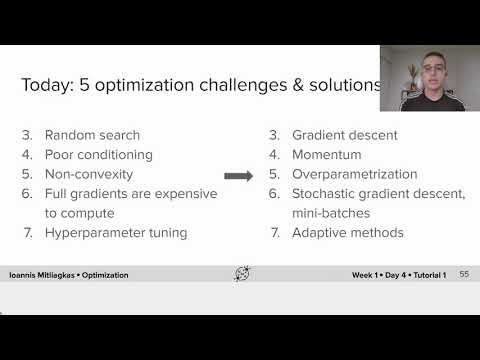

In [34]:
#@title Video 8: Putting it all together
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="DP9c13vLiOM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In [35]:
# Download parameters of the benchmark model
import urllib.request
urllib.request.urlretrieve("https://jgalle29.github.io/resources/benchmark_model.pt", "benchmark_model.pt")

# Create MLP object and update weights with those of saved model
benchmark_model = MLP(in_dim=784, out_dim=10, hidden_dims=[200, 100, 50])
benchmark_model.load_state_dict(torch.load('benchmark_model.pt'))

<All keys matched successfully>

We define an optimizer in the following steps:

1. Load  the corresponding class that implements the parameter updates and other internal management activities, including:
    - create auxiliary variables,
    - update moving averages,
    - adjust learning rate.
2. Pass the parameters of the Pytorch model that the optimizer has control over. Note that different parameter groups can potentially be controlled by different optimizers.
3. Specify hyperparameters, including learning rate, momentum, moving average factors, etc.



### Exercise 5: Train your own model

Now, train the model with your preferred optimizer and find a good combination of hyperparameter settings.

In [36]:
# Note to reviewers: should we use cuda in this section? Has this been covered in
# past days?
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [37]:
#################################################
## TODO for students: adjust hyper-parameters ##

MAX_EPOCHS = 1
LR = 1e-4
BATCH_SIZE = 64

# Define the model and associated optimizer -- to keep things fair, we use the
# same architecture.
model = MLP(in_dim=784, out_dim=10, hidden_dims=[200, 100, 50])

if USE_CUDA:
    model.cuda()

# You might want to try out different optimizers
# Options: torch.optim.RMSprop, torch.optim.Adagrad, torch.optim.Adam
# Check the optimizer documentation and hyperparameter meaning before using!
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
#################################################

In [38]:
# Load data using a Pytorch Dataset
train_set, test_set = load_mnist_data(change_tensors=False)

# Create the corresponding DataLoaders for training and test
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256)

# Run training
metrics = {'loss':[], 'acc':[]}
for epoch in range(MAX_EPOCHS):

    running_loss, running_acc = 0., 0.

    for batch_id, batch in enumerate(train_loader):

        # Extract minibatch data
        batch_x, batch_y = batch[0].to(DEVICE), batch[1].to(DEVICE)

        # Just like before, refresh gradient accumulators.
        # Note that this is now a method of the optimizer.
        optimizer.zero_grad()

        # Evaluate model and loss on minibatch
        preds = model(batch_x)
        loss = loss_fn(preds, batch_y)
        acc = torch.mean(1.0 * (preds.argmax(dim=1) == batch_y))

        # Compute gradients
        loss.backward()

        # Update parameters
        # Note how all the magic in the update of the parameters is encapsulated by
        # the optimizer class.
        optimizer.step()

        # Log metrics for plotting
        metrics['loss'].append(loss.cpu().item())
        metrics['acc'].append(acc.cpu().item())

        # print statistics
        running_loss += loss.cpu().item()
        running_acc += acc.cpu().item()
        if batch_id % 100 == 99: # Log every 100 batches
            print('Epoch %d - Batch %d - Loss: %.3f - Acc: %.3f' %
                  (epoch + 1, batch_id + 1, running_loss / 100, running_acc / 100))
            running_loss, running_acc = 0., 0.

Epoch 1 - Batch 100 - Loss: 2.307 - Acc: 0.062
Epoch 1 - Batch 200 - Loss: 2.306 - Acc: 0.058
Epoch 1 - Batch 300 - Loss: 2.305 - Acc: 0.068
Epoch 1 - Batch 400 - Loss: 2.305 - Acc: 0.062
Epoch 1 - Batch 500 - Loss: 2.303 - Acc: 0.060
Epoch 1 - Batch 600 - Loss: 2.305 - Acc: 0.058
Epoch 1 - Batch 700 - Loss: 2.305 - Acc: 0.058
Epoch 1 - Batch 800 - Loss: 2.304 - Acc: 0.063
Epoch 1 - Batch 900 - Loss: 2.305 - Acc: 0.062


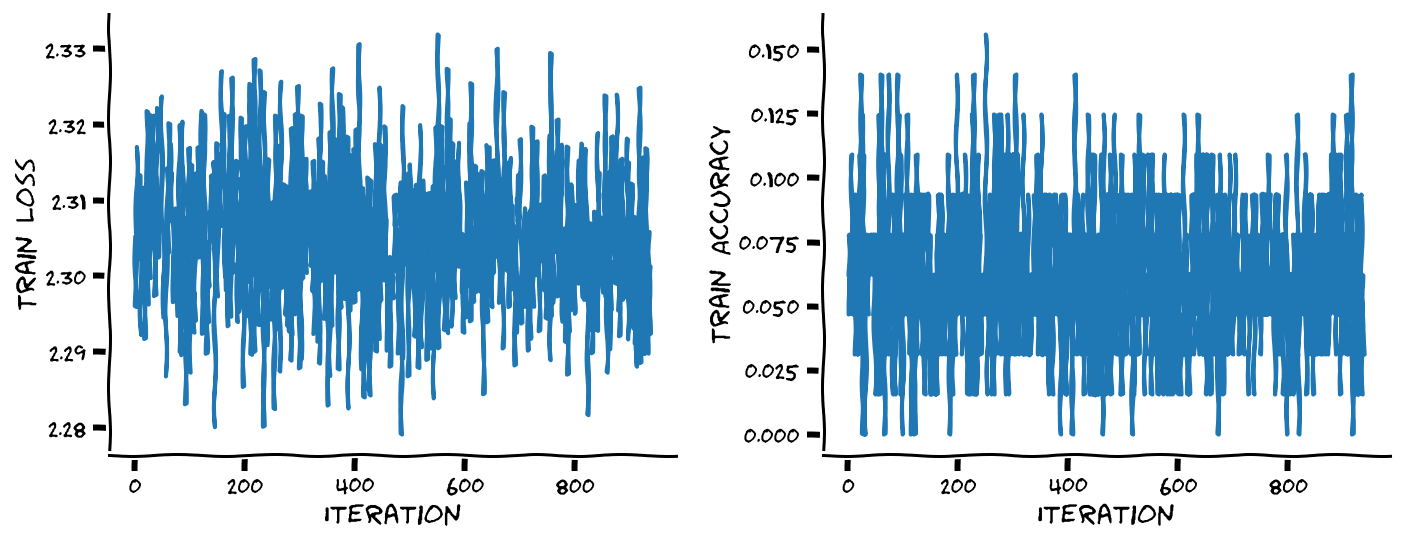

In [39]:
with plt.xkcd():
    fig, ax = plt.subplots(1, 2, figsize=(10,4))

    ax[0].plot(range(len(metrics['loss'])), metrics['loss'])
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Train Loss')

    ax[1].plot(range(len(metrics['acc'])), metrics['acc'])
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Train Accuracy')

### Evaluation

In [40]:
# Performance of your model

def eval_model(model, data_loader):

    loss_log, acc_log = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device=device)

    with torch.no_grad():

        for batch_id, batch in enumerate(data_loader):

            # Extract minibatch data
            batch_x, batch_y = batch[0].to(device), batch[1].to(device)

            # Evaluate model and loss on minibatch
            preds = model(batch_x)
            loss_log.append(loss_fn(preds, batch_y).item())
            acc_log.append(torch.mean(1. * (preds.argmax(dim=1) == batch_y)).item())

    return np.mean(loss_log), np.mean(acc_log)

print('Your model')
train_loss, train_accuracy = eval_model(model, train_loader)
test_loss, test_accuracy = eval_model(model, test_loader)
print('Train/Test Loss', train_loss, test_loss)
print('Train/Test Accuracy', train_accuracy, test_accuracy)

print('\nBenchmark model')
train_loss, train_accuracy = eval_model(benchmark_model, train_loader)
test_loss, test_accuracy = eval_model(benchmark_model, test_loader)
print('Train/Test Loss', train_loss, test_loss)
print('Train/Test Accuracy', train_accuracy, test_accuracy)

Your model
Train/Test Loss 2.3025774160173658 2.302380084991455
Train/Test Accuracy 0.06534848081023455 0.06396484375

Benchmark model
Train/Test Loss 0.010332989438628303 0.025285139086190612
Train/Test Accuracy 0.9979510927505331 0.9931640625


# 9. Ethical concerns

Video available at https://youtu.be/0EthSI0cknI


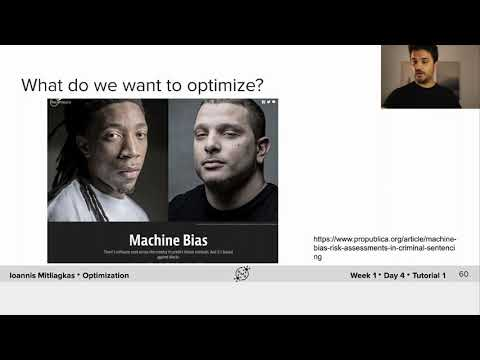

In [41]:
#@title Video 9: Ethical concerns
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="0EthSI0cknI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
# Summary

* Optimization is necessary to create Deep Learning models that are guaranteed to converge 
* Stochastic Gradient Descent and Momentum are two commonly used optimization techniques
* RMSProp is a way of adaptive hyper parameter tuning which utilises a per-dimension learning rate
* Poor choice of optimization functions can lead to unforeseen undesirable consequences 
